# Задача 4. Ансамбли

Датасет - https://www.kaggle.com/datasets/imtkaggleteam/household-power-consumption

Более 100 мб, поэтому на гит не загружен

## Список задач
1. Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
3. Самостоятельно реализуйте алгоритмы Bagging и AdaBoost, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
4. Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из sklearn (Bagging, Random Forest, AdaBoost, Gradient Tree Boosting, Histogram-Based Gradient Boosting).
5. При обучении использовать подбор гиперпараметров, кросс-валидацию.
6. Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
7. Также добавить в сравнение модели из библиотек XGBoost, LightGBM и CatBoost.
8. Для подбора гиперпараметров использовать фреймворк Optuna.

## 0. Импорт библиотек

In [1]:
!pip install catboost
!pip install optuna
!pip install --upgrade scikit-learn==1.2.2
!pip install --upgrade xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2

In [24]:
from enum import Enum
import time
import copy
from IPython.display import display

import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import holidays

from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

import optuna

## 1. Выбор данных



Household Electric Power Consumption
time series analysis - regression / clustering

Потребление электроэнергии домохозяйств
анализ временных рядов - регрессия / кластеризация

Контекст: Измерения потребления электроэнергии в одном домашнем хозяйстве с частотой дискретизации в одну минуту за период почти в 4 года. Доступны различные электрические величины и некоторые дополнительные значения измерений.

**Характеристики набора данных:**
Многомерные временные ряды

**Информация о наборе данных:**

Этот архив содержит 2075259 измерений, собранных в период с декабря 2006 года по ноябрь 2010 года (47 месяцев).

Примечания:
1. (global_active_power * 1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) представляет активную энергию, потребляемую ежеминутно (в ватт-часах) в домашнем хозяйстве электрическим оборудованием, не измеряемым в субметрах 1, 2 и 3.

2. Набор данных содержит некоторые недостающие значения в измерениях (почти 1,25% строк). Все временные метки календаря присутствуют в наборе данных, но для некоторых временных меток значения измерений отсутствуют: отсутствующее значение представлено отсутствием значения между двумя последовательными разделителями атрибутов точкой с запятой. Например, в наборе данных отсутствуют значения по состоянию на 28 апреля 2007 года.

Колонки:
1. Date: дата в формате дд / мм/ гггг

2. Time: время в формате чч: мм: сс

3. Global_active_power: усредненная по минутам активная мощность домохозяйства (в киловаттах)

4. Global_reactive_power: усредненная по минутам реактивная мощность домохозяйства (в киловаттах)

5. Voltage: усредненное по минутам напряжение (в вольтах)

6. Global_intensity: усредненная по минутам сила тока в домашнем хозяйстве (в амперах)

7. Sub_metering_1: подсчет энергии № 1 (в ватт-часах активной энергии). Она соответствует кухне, оснащенной в основном посудомоечной машиной, духовкой и микроволновой печью (плиты не электрические, а газовые).

8. Sub_metering_2: подсчет энергии № 2 (в ватт-часах активной энергии). Это соответствует прачечной, в которой есть стиральная машина, сушилка для белья, холодильник и лампа.

9. Sub_metering_3: подсчет энергии № 3 (в ватт-часах активной энергии). Он соответствует электрическому водонагревателю и кондиционеру воздуха.


In [3]:
df = pl.read_csv(
    "./household_power_consumption.txt",
    separator=";",
    null_values=["?"]  # '?' == null
)

df_np = df.to_numpy()

## 2. EDA

In [4]:
df

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
str,str,f64,f64,f64,f64,f64,f64,f64
"""16/12/2006""","""17:24:00""",4.216,0.418,234.84,18.4,0.0,1.0,17.0
"""16/12/2006""","""17:25:00""",5.36,0.436,233.63,23.0,0.0,1.0,16.0
"""16/12/2006""","""17:26:00""",5.374,0.498,233.29,23.0,0.0,2.0,17.0
"""16/12/2006""","""17:27:00""",5.388,0.502,233.74,23.0,0.0,1.0,17.0
"""16/12/2006""","""17:28:00""",3.666,0.528,235.68,15.8,0.0,1.0,17.0
…,…,…,…,…,…,…,…,…
"""26/11/2010""","""20:58:00""",0.946,0.0,240.43,4.0,0.0,0.0,0.0
"""26/11/2010""","""20:59:00""",0.944,0.0,240.0,4.0,0.0,0.0,0.0
"""26/11/2010""","""21:00:00""",0.938,0.0,239.82,3.8,0.0,0.0,0.0


Все столбцы, кроме даты и времени, числовые. Преобразуем для начала их в один столбец типа Datetime для дальнейшего создания новых колонок.

In [5]:
df = df.with_columns(
    (pl.col("Date") + " " + pl.col("Time"))
    .str.to_datetime(format="%d/%m/%Y %H:%M:%S")
    .alias("datetime")
)

In [6]:
df

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
str,str,f64,f64,f64,f64,f64,f64,f64,datetime[μs]
"""16/12/2006""","""17:24:00""",4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
"""16/12/2006""","""17:25:00""",5.36,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
"""16/12/2006""","""17:26:00""",5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
"""16/12/2006""","""17:27:00""",5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
"""16/12/2006""","""17:28:00""",3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00
…,…,…,…,…,…,…,…,…,…
"""26/11/2010""","""20:58:00""",0.946,0.0,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00
"""26/11/2010""","""20:59:00""",0.944,0.0,240.0,4.0,0.0,0.0,0.0,2010-11-26 20:59:00
"""26/11/2010""","""21:00:00""",0.938,0.0,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00


In [7]:
# удаляем исходные колонки за ненадобностью
df = df.drop(["Date", "Time"])

Для начала я уменьшу частоту дискретизации с одной минуты до пяти, в целях облегчения своей работы.

Если рассматривать такое преобразование с промышленной, реальной точки зрения, оно наверное вредно (хотя поминутные данные очевидно менее стабильны и содержат много шума), т.к. реально используемые методики могут из поминутных данных "выудить" много полезной информации, а сглаживая их, мы соответственно эти данные теряем.

Изначально хотел снизить частоту до раза в час, но это уже точно неоправданное преобразование (точнее, на таких данных можно попробовать построить отдельную модель, и добавить её в некоторый ансамбль). Красноречивый пример: можно представить потребление энергии в 7 часов утра и в 8, когда в один момент многие начинают просыпаться, включать различные энергоёмкие электроприборы, а в 8 часов уже покидают дома.

UPD: далее по блокноту я понял, что работать с таким кол-вом строк в рамках учебной задачи - избыточно, ибо это занимает много времени. Но т.к. мне хотелось взять больший период наблюдений, я решил понизить частоту дискретизации до 15 минут.

In [8]:
vanilla_columns = df.columns[:-1]

# Применяем агрегацию через list comprehension. Срез выполняется, чтобы не брать в функцию аггрегации datetime (Это последняя колонка, т.к. она вручную создана)
aggregations = [pl.col(col).mean().alias(col) for col in vanilla_columns]

# Группировка с агрегацией
df = df.group_by_dynamic(
    index_column="datetime", # Колонка с временными метками
    every="15m",              # Интервал агрегации (каждые 5 минут)
    period="15m"              # Окно, покрывающее 5 минут
).agg(aggregations)

In [9]:
df

datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64
2006-12-16 17:15:00,4.587333,0.484,234.366667,19.7,0.0,1.333333,16.833333
2006-12-16 17:30:00,4.140667,0.327733,234.768667,17.773333,0.0,0.733333,16.866667
2006-12-16 17:45:00,4.159333,0.028267,234.63,17.786667,0.0,0.0,16.866667
2006-12-16 18:00:00,4.121067,0.152533,235.566,17.706667,0.0,19.933333,17.0
2006-12-16 18:15:00,3.768533,0.0172,234.803333,16.226667,0.0,2.866667,16.933333
…,…,…,…,…,…,…,…
2010-11-26 20:00:00,1.634533,0.058,239.539333,6.933333,0.0,1.4,0.0
2010-11-26 20:15:00,1.078933,0.117067,240.094667,4.56,0.0,1.2,0.0
2010-11-26 20:30:00,0.9792,0.047867,238.822667,4.12,0.0,1.133333,0.0


Метку времени логично разложить на несколько колонок, каждая из которых характеризует одну из составляющих - год, месяц, день, час, минута, секунда.

Также в работе с временными рядами очень часто используется "циклическое кодирование". То есть, чтобы условные "23 час" и "0 час" не считывались методом, как диаметрально противоположные, а наоборот были закодированы близкими числами. Для этого и используется кодирование тригонометрическими функциями, такими как sin и cos.

Но, изучив вопрос подробнее, в одной из итераций курса "Нейронные сети и их применение в научных исследованиях" на [лекции о генерации признаков](https://edunet.kea.su/repo/msu_ai/1.9_html/L04_Feature_Engineering.html), был замечен такой тезис:

> В случае с такими признаками, как день недели или время суток, мы сталкиваемся с проблемой того, что нам нужно предложить кодирование, которое будет учитывать, что понедельник близок к воскресенью так же, как и ко вторнику, и т.д. В случае деревьев решений и методов, на них основанных, можно "забить": такие методы сами разберутся. Для некоторых других методов, тех же нейросетей, правильно кодирование может улучшить качество и сходимость.

Я, честности ради, не уверен, как эти методы "должны разобраться", ибо они не способы строить разделение на условие в одной ветви, допустим "$x < 5$ или $x > 10$", а в другой "$x \in [5;10]$".

Поэтому я всё же добавляю циклическое кодирование и, в дальнейшем, посмотрю как влияет на качество предсказаний градиентного бустинга наличие или отсутствие таких переменных.

In [10]:
# Извлечение компонентов даты и времени
df = df.with_columns([
    pl.col("datetime").dt.year().alias("year"),
    pl.col("datetime").dt.month().alias("month"),
    pl.col("datetime").dt.day().alias("day"),
    pl.col("datetime").dt.weekday().alias("weekday"),
    pl.col("datetime").dt.hour().alias("hour"),
    pl.col("datetime").dt.minute().alias("minute")
])

# Добавление циклических признаков
df = df.with_columns([
    (2 * np.pi * pl.col("month") / 12).sin().alias("month_sin"),
    (2 * np.pi * pl.col("month") / 12).cos().alias("month_cos")
])

df = df.with_columns([
    (2 * np.pi * pl.col("day") / 365).sin().alias("day_sin"),
    (2 * np.pi * pl.col("day") / 365).cos().alias("day_cos")
])

df = df.with_columns([
    (2 * np.pi * pl.col("weekday") / 7).sin().alias("weekday_sin"),
    (2 * np.pi * pl.col("weekday") / 7).cos().alias("weekday_cos")
])

df = df.with_columns([
    (2 * np.pi * pl.col("hour") / 24).sin().alias("hour_sin"),
    (2 * np.pi * pl.col("hour") / 24).cos().alias("hour_cos")
])

df = df.with_columns([
    (2 * np.pi * pl.col("minute") / 4).sin().alias("minute_sin"),
    (2 * np.pi * pl.col("minute") / 4).cos().alias("minute_cos")
])

In [11]:
cyclic_columns = [col for col in df.columns if "sin" in col or "cos" in col]
noncyclic_columns = ['month', 'day', 'weekday', 'hour', 'minute']

In [ ]:
df

datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,month,day,weekday,hour,minute,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
datetime[μs],f64,f64,f64,f64,f64,f64,f64,i32,i8,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2006-12-16 17:15:00,4.587333,0.484,234.366667,19.7,0.0,1.333333,16.833333,2006,12,16,6,17,15,-2.4493e-16,1.0,0.271958,0.962309,-0.781831,0.62349,-0.965926,-0.258819,-1.0,-2.6948e-15
2006-12-16 17:30:00,4.140667,0.327733,234.768667,17.773333,0.0,0.733333,16.866667,2006,12,16,6,17,30,-2.4493e-16,1.0,0.271958,0.962309,-0.781831,0.62349,-0.965926,-0.258819,5.3897e-15,-1.0
2006-12-16 17:45:00,4.159333,0.028267,234.63,17.786667,0.0,0.0,16.866667,2006,12,16,6,17,45,-2.4493e-16,1.0,0.271958,0.962309,-0.781831,0.62349,-0.965926,-0.258819,1.0,9.7910e-16
2006-12-16 18:00:00,4.121067,0.152533,235.566,17.706667,0.0,19.933333,17.0,2006,12,16,6,18,0,-2.4493e-16,1.0,0.271958,0.962309,-0.781831,0.62349,-1.0,-1.8370e-16,0.0,1.0
2006-12-16 18:15:00,3.768533,0.0172,234.803333,16.226667,0.0,2.866667,16.933333,2006,12,16,6,18,15,-2.4493e-16,1.0,0.271958,0.962309,-0.781831,0.62349,-1.0,-1.8370e-16,-1.0,-2.6948e-15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2010-11-26 20:00:00,1.634533,0.058,239.539333,6.933333,0.0,1.4,0.0,2010,11,26,5,20,0,-0.5,0.866025,0.432776,0.901502,-0.974928,-0.222521,-0.866025,0.5,0.0,1.0
2010-11-26 20:15:00,1.078933,0.117067,240.094667,4.56,0.0,1.2,0.0,2010,11,26,5,20,15,-0.5,0.866025,0.432776,0.901502,-0.974928,-0.222521,-0.866025,0.5,-1.0,-2.6948e-15
2010-11-26 20:30:00,0.9792,0.047867,238.822667,4.12,0.0,1.133333,0.0,2010,11,26,5,20,30,-0.5,0.866025,0.432776,0.901502,-0.974928,-0.222521,-0.866025,0.5,5.3897e-15,-1.0


Дальше обработаем пустые строки, что ранее было обозначено в примечании

In [ ]:
df = df.with_columns(
    pl.col("datetime")
      .cast(pl.Datetime("ms"))
)

In [ ]:
df.filter(pl.col("Global_active_power").is_null())

datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,month,day,weekday,hour,minute,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
datetime[ms],f64,f64,f64,f64,f64,f64,f64,i32,i8,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2007-04-28 00:30:00,null,null,null,null,null,null,null,2007,4,28,6,0,30,0.866025,-0.5,0.46355,0.886071,-0.781831,0.62349,0.0,1.0,5.3897e-15,-1.0
2007-04-28 00:45:00,null,null,null,null,null,null,null,2007,4,28,6,0,45,0.866025,-0.5,0.46355,0.886071,-0.781831,0.62349,0.0,1.0,1.0,9.7910e-16
2007-04-28 01:00:00,null,null,null,null,null,null,null,2007,4,28,6,1,0,0.866025,-0.5,0.46355,0.886071,-0.781831,0.62349,0.258819,0.965926,0.0,1.0
2007-04-28 01:15:00,null,null,null,null,null,null,null,2007,4,28,6,1,15,0.866025,-0.5,0.46355,0.886071,-0.781831,0.62349,0.258819,0.965926,-1.0,-2.6948e-15
2007-04-28 01:30:00,null,null,null,null,null,null,null,2007,4,28,6,1,30,0.866025,-0.5,0.46355,0.886071,-0.781831,0.62349,0.258819,0.965926,5.3897e-15,-1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2010-09-28 17:45:00,null,null,null,null,null,null,null,2010,9,28,2,17,45,-1.0,-1.8370e-16,0.46355,0.886071,0.974928,-0.222521,-0.965926,-0.258819,1.0,9.7910e-16
2010-09-28 18:00:00,null,null,null,null,null,null,null,2010,9,28,2,18,0,-1.0,-1.8370e-16,0.46355,0.886071,0.974928,-0.222521,-1.0,-1.8370e-16,0.0,1.0
2010-09-28 18:15:00,null,null,null,null,null,null,null,2010,9,28,2,18,15,-1.0,-1.8370e-16,0.46355,0.886071,0.974928,-0.222521,-1.0,-1.8370e-16,-1.0,-2.6948e-15


Мы видим последовательно пустые значения (т.е., видимо, ввиду каких-то причин, данные могли просто не записываться). И так как ряды подряд идущих пустых значений довольно длинные, простейшие методы заполнения на основе:
* Заполнение предыдущим или следующим значением
* Заполнение скользящим окном
* Заполнение интерполяцией (допустим, линейной регрессией)

не подойдут. Можно было бы скопировать полностью значения предыдущего дня, но вариант тоже не очень.

Моё предложение - заполнить все эти пустые значения путём прогнозирования легковесной, но довольно мощной библиотекой fbprophet.

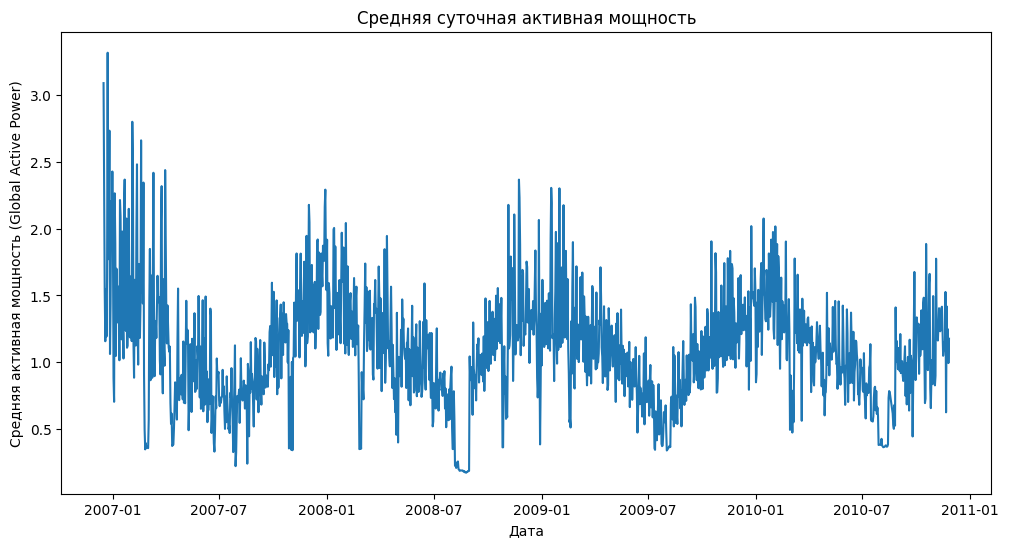

In [ ]:
df = df.with_columns(pl.col('datetime').dt.truncate('1d').alias('date'))

# Группируем данные по дате и рассчитываем среднее значение Global_active_power
daily_df = df.group_by('date').agg(pl.col('Global_active_power').mean().alias('avg_power'))

# Конвертируем результат в Pandas для построения графика
daily_df_pandas = daily_df.to_pandas()

# Построение графика
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_df_pandas, x='date', y='avg_power')
plt.title('Средняя суточная активная мощность')
plt.xlabel('Дата')
plt.ylabel('Средняя активная мощность (Global Active Power)')
plt.show()

Тренд определённо есть (спадающий, видимо последствия экономического кризиса 2008). Сезонность тоже очевидна (годовая, что видно. Недельную и дневную не видно, но их присутствие очевидны) и она скорее аддитивная, чем мультипликативная (ибо изменение дисперсии значений от периода к периоду несущественны)

Создадим через библиотеку holidays список праздников и подадим модели, она это позволяет. Это некоторые особые условия (экзогенная переменная), которые помогут модели лучше ориентироваться в предсказании.

Т.к. датасет распространялся на UCI Machine Learning Repository, т.е. университетом из США штата Калифорния, то соответственно берём их праздники за наблюдаемые годы.

In [ ]:
# Уменьшим кол-во строк для облегчения задачи
df = df[:60000]

In [ ]:
years = df["year"].unique().to_list()

# Генерируем американские праздники для всех лет из данных
us_holidays = holidays.US(years=years)

# Преобразуем праздники в формат DataFrame для Prophet
holidays_df = pd.DataFrame([
    {'holiday': name, 'ds': date} for date, name in us_holidays.items()
])

In [ ]:
def make_dates_df(df: pl.DataFrame, freq: str = "15min") -> pd.DataFrame:
    """
    Генерирует pandas DataFrame со сплошной датой (ds)
    от минимальной datetime до максимальной, с заданным freq (например '15min').
    """
    min_dt = df.select(pl.col("datetime").min()).item()
    max_dt = df.select(pl.col("datetime").max()).item()

    all_idx = pd.date_range(start=min_dt, end=max_dt, freq=freq)
    dates_pd = pd.DataFrame({"ds": all_idx})
    return dates_pd

def make_us_holidays_df(start_year: int = 2006, end_year: int = 2010) -> pd.DataFrame:
    """
    Создаёт DataFrame с праздничными датами в США за заданный диапазон лет.
    Колонки: ['holiday', 'ds'].
    Понадобится для передачи в Prophet (через параметр holidays).
    """
    # end_year включаем, поэтому +1 не нужно или наоборот, смотря как хотим
    years = range(start_year, end_year + 1)

    # Инициализация американских праздников
    us_holidays = holidays.US(years=years)

    # Формируем список словарей {holiday: ..., ds: ...}
    records = []
    for date, name in us_holidays.items():
        records.append({
            'holiday': name,
            'ds': date  # Prophet ожидает дату в колонке ds
        })

    # Преобразуем в DataFrame
    holidays_df = pd.DataFrame(records)

    # Убедимся, что ds в формате datetime
    holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])

    return holidays_df

def fill_null_by_prophet(df: pl.DataFrame,
                         col: str,
                         dates: pd.DataFrame,
                         holidays_df: pd.DataFrame = None) -> pl.DataFrame:
    """
    Заполняет пропуски в столбце col с помощью модели Prophet.
    """
    ts_pd = df.select(["datetime", col]).to_pandas()
    ts_pd = ts_pd.rename(columns={"datetime": "ds", col: "y"})

    full_pd = pd.merge(dates, ts_pd, how="left", on="ds")

    train_pd = full_pd.dropna(subset=["y"]).copy()
    if len(train_pd) < 2:
        print(f"[WARNING] Не удалось обучить Prophet для {col}, данных слишком мало.")
        return df

    model = Prophet(
        holidays=holidays_df,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    model.fit(train_pd)

    forecast = model.predict(full_pd)
    full_pd = pd.merge(full_pd, forecast[["ds", "yhat"]], on="ds", how="left")

    mask = full_pd["y"].isna()
    full_pd.loc[mask, "y"] = full_pd.loc[mask, "yhat"]
    full_pd = full_pd.drop(columns=["yhat"])

    filled_pl = pl.from_pandas(full_pd.rename(columns={"y": col}))

    if df.schema["datetime"] == pl.Datetime("ms"):
        filled_pl = filled_pl.with_columns(
            pl.col("ds").cast(pl.Datetime("ms"))
        )

    filled_pl = filled_pl.select([
        "ds",
        pl.col(col).alias(f"{col}_prophet")
    ])

    result = df.join(
        filled_pl,
        left_on="datetime",
        right_on="ds",
        how="left"
    )

    if col in result.columns:
        result = result.rename({col: f"{col}_old"})
    prophet_col = f"{col}_prophet"
    if prophet_col in result.columns:
        result = result.rename({prophet_col: col})
    if "ds" in result.columns:
        result = result.drop("ds")

    return result

In [ ]:
dates = make_dates_df(df, freq="15min")
holidays_df = make_us_holidays_df(start_year=2006, end_year=2010)

for col in vanilla_columns:
    df = fill_null_by_prophet(df, col, dates, holidays_df)

In [ ]:
df.write_csv('processed_household_power_consumption.csv')

In [12]:
df = pl.read_csv('processed_household_power_consumption.csv')
df = df.drop('date')
df = df.with_columns(
    pl.col("datetime")
    .str.to_datetime(format="%Y-%m-%dT%H:%M:%S.%f")
)

<ipython-input-12-1dd3178c1879>:4: ChronoFormatWarning: Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime
  pl.col("datetime")


In [ ]:
df.filter(pl.any_horizontal(pl.all().is_null()))

datetime,year,month,day,weekday,hour,minute,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime[μs],i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64


Пропусков нет.

Глянем на корреляцию признаков.

<Axes: >

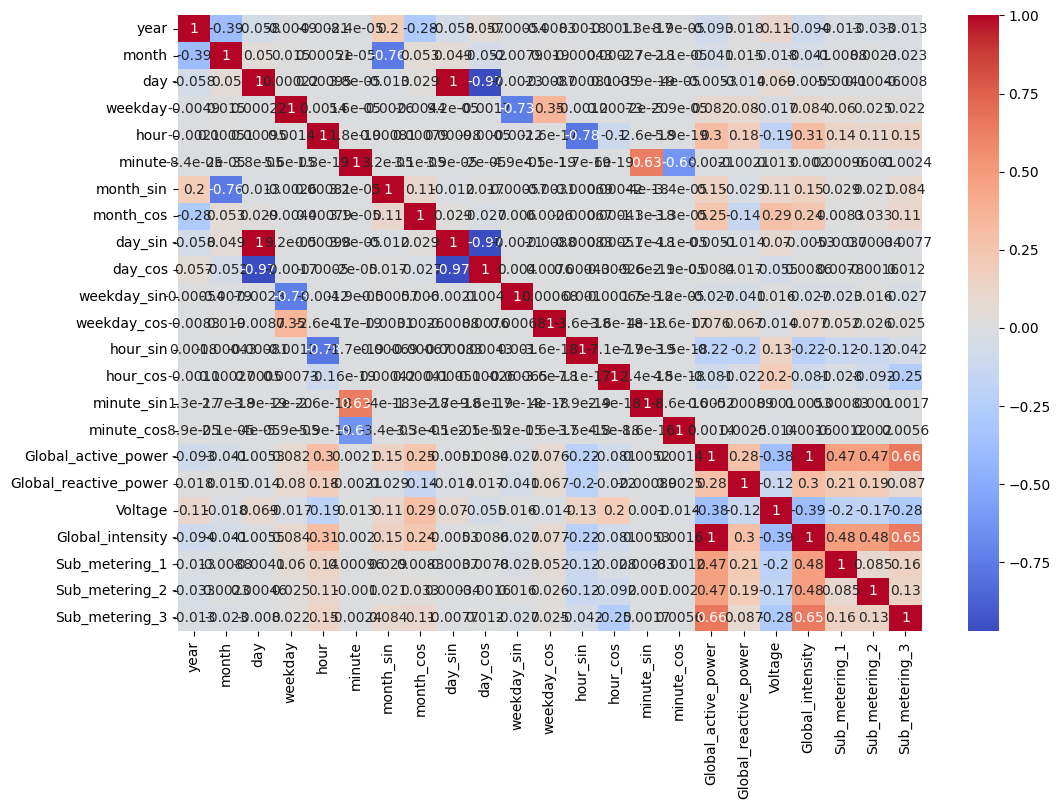

In [ ]:
plt.figure(figsize=(12, 8))

sns.heatmap(df.select(df.columns[1:]).to_pandas().corr(), annot=True, cmap="coolwarm")

Выглядит не очень)). Но какие промежуточные выводы можно сделать? Большинство исходных столбцов временных меток - скоррелированны частично или полностью со своими преобразованными периодическими столбцами. Для непараметрических методов скоррелированность признаков - не проблема, но они просто напросто избыточны.

Можно оставить временные метки в одном из двух видов. Но опять же, прежде чем что-то удалять, я проверю, с какими столбцами методы бустинга лучше работают

<Axes: >

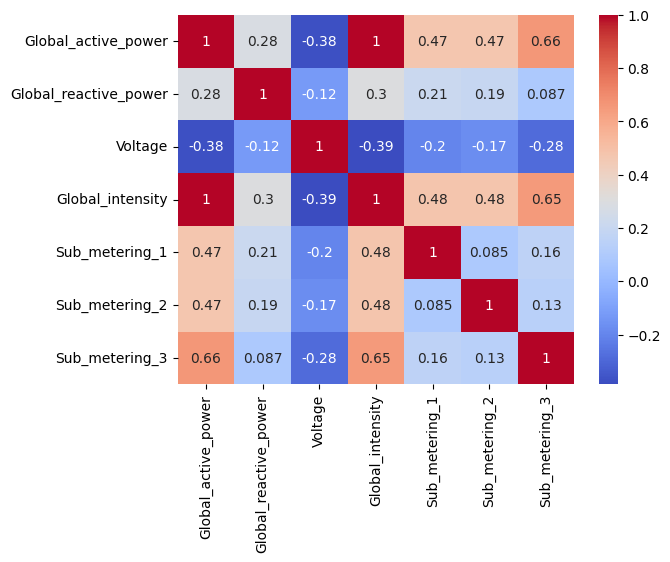

In [ ]:
sns.heatmap(df.select(vanilla_columns).to_pandas().corr(), annot=True, cmap="coolwarm")

Global_intensity определённо дропаем. А корреляция $\approx$ 0.66 не очень, но жить можно.

На данном этапе я понял, что выбрать данные с временными рядами, не было лучшим решением, потому что у меня по сути для прогнозирования в будущее нет каких-то фичей, кроме меток времени, ибо использовать другие временные ряды - неправильно, т.к. по своей семантике они все связаны, т.к. показывают траты электроэнергии одного и того же домохозяйства.

Тем не менее, остановлюсь на этих данных, ибо было проделано много работы.

In [13]:
df = df.drop('Global_intensity')

In [ ]:
def prepare_data_catboost_random_split(
    df: pl.DataFrame,
    ignore_cols: list,
    target_col: str = "Global_active_power",
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple[Pool, Pool]:
    """
    Делит Polars DataFrame на train и test в пропорции (1 - test_size)/test_size
    случайным образом, а затем формирует Pool для CatBoost.

    Аргументы:
      - df: Polars DataFrame
      - ignore_cols: список колонок, которые не надо включать как фичи
      - target_col: имя столбца-цели
      - test_size: доля (например, 0.2 = 80% train, 20% test)
      - random_state: для воспроизводимости случайного разбиения

    Возвращает: (train_pool, test_pool)
    """
    df_pd = df.to_pandas()

    all_cols = df_pd.columns.tolist()
    features = [c for c in all_cols if c not in ignore_cols and c != target_col]

    X = df_pd[features]
    y = df_pd[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)

    return train_pool, test_pool

def catboost_fit_predict(
    train_pool,
    test_pool,
    iterations: int = 3000,
    depth: int = 6,
    learning_rate: float = 0.1
):
    """
    Обучает CatBoostRegressor на train_pool, делает предсказание на test_pool
    и выводит метрику (MSE).

    Input:
      - train_pool, test_pool: объекты catboost.Pool
      - iterations: количество итераций (деревьев)
      - depth: глубина дерева
      - learning_rate: скорость обучения

    Output:
      - model: обученная модель CatBoostRegressor
      - mse: значение метрики (Mean Squared Error) на тесте
    """
    model = CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        verbose=False
    )

    model.fit(train_pool, eval_set=test_pool, verbose=500)

    y_pred = model.predict(test_pool)
    y_true = test_pool.get_label()

    mse = mean_squared_error(y_true, y_pred)

    return mse

In [ ]:
train_pool, test_pool = prepare_data_catboost_random_split(
    df=df,
    ignore_cols=['datetime', *cyclic_columns, *noncyclic_columns],
    target_col="Global_active_power",
    test_size=0.2,
    random_state=42
)

best_metric, best_depth = 0, 0

for depth in range(1, 7):
  print(f'Depth = {depth}')
  mse = catboost_fit_predict(train_pool, test_pool, iterations=3000, depth=depth)
  if best_metric < mse:
    best_metric = mse
    best_depth = depth

print(f'Best metric = {best_metric}')
print(f'Best depth = {best_depth}')

Depth = 1
0:	learn: 1.0253519	test: 0.9967472	best: 0.9967472 (0)	total: 51.4ms	remaining: 2m 34s
500:	learn: 0.5365359	test: 0.5212218	best: 0.5212218 (500)	total: 1.89s	remaining: 9.42s
1000:	learn: 0.5340430	test: 0.5193284	best: 0.5193284 (998)	total: 3.7s	remaining: 7.39s
1500:	learn: 0.5331937	test: 0.5188521	best: 0.5188518 (1499)	total: 7.08s	remaining: 7.07s
2000:	learn: 0.5327538	test: 0.5185951	best: 0.5185903 (1970)	total: 9.65s	remaining: 4.82s
2500:	learn: 0.5324704	test: 0.5184485	best: 0.5184457 (2492)	total: 11.4s	remaining: 2.28s
2999:	learn: 0.5322624	test: 0.5183325	best: 0.5183307 (2998)	total: 13.3s	remaining: 0us

bestTest = 0.5183307288
bestIteration = 2998

Shrink model to first 2999 iterations.
Depth = 2
0:	learn: 1.0117408	test: 0.9829706	best: 0.9829706 (0)	total: 4.78ms	remaining: 14.3s
500:	learn: 0.5182711	test: 0.5044114	best: 0.5044114 (500)	total: 2.08s	remaining: 10.4s
1000:	learn: 0.5133144	test: 0.5014510	best: 0.5014510 (1000)	total: 4.13s	remainin

In [ ]:
train_pool, test_pool = prepare_data_catboost_random_split(
    df=df,
    ignore_cols=['datetime', *noncyclic_columns],
    target_col="Global_active_power",
    test_size=0.2,
    random_state=42
)

best_metric, best_depth = 0, 0

for depth in range(1, 7):
  print(f'Depth = {depth}')
  mse = catboost_fit_predict(train_pool, test_pool, iterations=3000, depth=depth)
  if best_metric < mse:
    best_metric = mse
    best_depth = depth

print(f'Best metric = {best_metric}')
print(f'Best depth = {best_depth}')

Depth = 1
0:	learn: 1.0253398	test: 0.9966383	best: 0.9966383 (0)	total: 5.9ms	remaining: 17.7s
500:	learn: 0.4529553	test: 0.4388247	best: 0.4388247 (500)	total: 3.27s	remaining: 16.3s
1000:	learn: 0.4476316	test: 0.4339355	best: 0.4339355 (1000)	total: 5.37s	remaining: 10.7s
1500:	learn: 0.4456806	test: 0.4321986	best: 0.4321986 (1500)	total: 7.47s	remaining: 7.46s
2000:	learn: 0.4447007	test: 0.4313557	best: 0.4313519 (1998)	total: 9.63s	remaining: 4.81s
2500:	learn: 0.4441137	test: 0.4308685	best: 0.4308685 (2500)	total: 11.7s	remaining: 2.34s
2999:	learn: 0.4437340	test: 0.4305615	best: 0.4305605 (2993)	total: 16s	remaining: 0us

bestTest = 0.430560513
bestIteration = 2993

Shrink model to first 2994 iterations.
Depth = 2
0:	learn: 1.0116712	test: 0.9825690	best: 0.9825690 (0)	total: 5.19ms	remaining: 15.6s
500:	learn: 0.4034562	test: 0.3906950	best: 0.3906908 (499)	total: 2.45s	remaining: 12.2s
1000:	learn: 0.3890559	test: 0.3781899	best: 0.3781899 (1000)	total: 4.92s	remaining: 

In [ ]:
train_pool, test_pool = prepare_data_catboost_random_split(
    df=df,
    ignore_cols=['datetime', *cyclic_columns],
    target_col="Global_active_power",
    test_size=0.2,
    random_state=42
)

best_metric, best_depth = 0, 0

for depth in range(1, 7):
  print(f'Depth = {depth}')
  mse = catboost_fit_predict(train_pool, test_pool, iterations=3000, depth=depth)
  if best_metric < mse:
    best_metric = mse
    best_depth = depth

print(f'Best metric = {best_metric}')
print(f'Best depth = {best_depth}')

Depth = 1
0:	learn: 1.0252995	test: 0.9967272	best: 0.9967272 (0)	total: 5.69ms	remaining: 17.1s
500:	learn: 0.4469183	test: 0.4335772	best: 0.4335772 (500)	total: 3.4s	remaining: 17s
1000:	learn: 0.4392920	test: 0.4260796	best: 0.4260796 (1000)	total: 5.31s	remaining: 10.6s
1500:	learn: 0.4365738	test: 0.4235894	best: 0.4235894 (1500)	total: 7.21s	remaining: 7.21s
2000:	learn: 0.4350919	test: 0.4221819	best: 0.4221819 (2000)	total: 9.14s	remaining: 4.56s
2500:	learn: 0.4341967	test: 0.4212886	best: 0.4212886 (2500)	total: 11.1s	remaining: 2.21s
2999:	learn: 0.4336119	test: 0.4207448	best: 0.4207414 (2996)	total: 14s	remaining: 0us

bestTest = 0.4207413765
bestIteration = 2996

Shrink model to first 2997 iterations.
Depth = 2
0:	learn: 1.0117626	test: 0.9844282	best: 0.9844282 (0)	total: 7.7ms	remaining: 23.1s
500:	learn: 0.4068573	test: 0.3951998	best: 0.3951998 (500)	total: 3.36s	remaining: 16.8s
1000:	learn: 0.3929784	test: 0.3831918	best: 0.3831918 (1000)	total: 5.6s	remaining: 11.

В градиентном бустинге, по крайней мере CatBoost, сработали лучше ванильные фичи.

In [14]:
all_cols = df.columns
features = [c for c in all_cols if c not in [*cyclic_columns, *noncyclic_columns]]

df = df[features]

## 3. Собственная имплементация Bagging и AdaBoost


Методики ансамблирования в машинном обучении — это подходы, предполагающие обучение нескольких моделей (зачастую простых, но в больших количествах) с последующим агрегированием их предсказаний. Ансамблирование может выполняться как параллельно, так и последовательно, и направлено на улучшение качества итогового предсказания мета-модели. Мета-модель может быть представлена одной объединяющей моделью, обученной на предсказаниях базовых моделей, или более простыми методами агрегирования, такими как усреднение ответов (аналог концепции "мудрости толпы").

Выделяют несколько основных видов ансамблирования моделей:

* Bagging (Бутстрэп-агрегирование) - множество простейших моделей параллельно обучаются на случайных подвыборках данных (**Bootstraping**). Выходы моделей аггрегируются в один итоговый ответ.

* Boosting - множество простейших моделей последовательно обучаются на ошибках предыдущей модели.

* Stacking - это тот же Bagging, только выходы не агрегируются, а подаются на вход **мета-модели**, которая обучается на этих данных и уже выдаёт итоговый ответ. В данном случае, данные делятся на train, validation и test.

* Blending - аналог stacking, но менее строгий, так как данные делятся только на train и test, базовые модели предсказывают на test, качество мета-модели тоже вычисляется на test.

Преимущества ансамблирования:

+ Снижает вероятность переобучения, так как разные модели компенсируют ошибки друг друга
+ Может сочетать сильные стороны алгоритмов различных типов
+ Хорошо работает на сложных и шумных данных

Недостатки ансамблирования:

- Увеличение вычислительных затрат
- Сложность настройки и интерпретации итогового результата
- Затраты могут быть не оправданы при неудачном выборе архитектуры ансамбля

### Bagging
Метод ансамблирования, использующийся в задачах классификации и регрессии. Основная суть - параллельно обучение множества моделей (обычно деревьев решений) на случайных подвыборках из тренировочных данных, получаемых посредством бутстрэп-семплинга.

Такие подвыборки могут пересекаться и содержать дубликаты объектов, а также их размер = размеру исходной выборки. Основная суть в том, что наборы данных будут уникальны, но всё также нести в себе основные свойства распределения тренировочной выборки, что обеспечивается законом больших чисел.

В конце, выходы моделей агрегируются путём усреднения в случае регрессии или голосовая в случае классификации.

Усреднение может быть взвешенное, но это не частное явление, т.к. трудно выделить "приоритетные" модели и то, на сколько они важнее других.

Голосование же может проходить в формате hard-voting, где берётся самый часто выбираемый моделями класс, и soft-voting, где по всем классам складываются вероятности принадлежности, получаемые из моделей, и выбирается класс с самой большой средней вероятностью.

Базовые модели, в классическом варианте, являются алгоритмами одного семейства или даже одного вида, с одними и теми же гиперпараметрами, так как это кратно облегчает настройку ансамбля.

Преимущества:
* Снижение переобучения (уменьшение вариации)
* Улучшение устойчивости к шуму
* Простота реализации

Недостатки:
* Высокая вычислительная сложность
* Отсутствие значительного эффекта на стабильных моделях (e.g. линейная регрессия)
* Не решает проблему смещения

Популярный пример: случайный лес - агрегирование ответов сотней решающих деревьев

### Stacking
Это в какой-то мере усовершенствованный bagging (но без использования сэмплирования), где выходы моделей не агрегируются, а являются входом для некоторой **мета-модели** (исходные признаки тоже можно подавать), причём скорее всего отличного от базовых моделей типа (для выявления некоторых иных зависимостей).

Шаги:
1. Разделение выборки на train, valid, test
2. Обучение базовых моделей (алгоритмов) на train выборке
3. Предсказание объектов базовыми моделями на valid выборке. Эти данные подаются на вход мета-модели
4. Мета-модель обучается и её качество вычисляется по предсказаниям на test

Примечание: если данных мало, то valid отсутствует, а train делится на k-folds (k-1 == кол-во базовых моделей), каждая из которых обучается на своём фолде, а предсказание для мета-модели делается на последнем фолде

Преимущества:
1. Улучшается точность
2. Уменьшается дисперсия


Недостатки:
1. Высокая вычислительная сложность
2. Не уменьшается смещение

### Blending
Упрощенная версия Stacking, где данные делятся лишь на train и test. Так допустимо делать, когда данных мало, но качество из-за обучения и оценке мета-модели на тесте падает

## Boosting
Последовательный метод обучения базовых моделей одного вида, где каждая следующая модель "исправляет" ошибки предыдущей.

### AdaBoost

Классической версией бустинга считается **AdaBoost** (Adaptive Boosting)

В классической постановке используется для задачи классификации, но есть возможность адаптировать алгоритм и для задачи регрессии.

Шаги AdaBoost:

1. Инициализация весов объектов - присваиваем каждому объекту один и тот же вес $w_i = \frac{1}{n}$, показывающий важность наблюдения для обучения. В дальнейшем вес будет расти у тех, на ком модели совершают ошибки.

2. Обучается первая "слабая" модель (частно это дерево решений глубины 1 - "пень"). Ошибка модели вычисляется по формуле $ε_t=\sum_{i=1}^{n} w_i * 1(h_t(x_i) \neq y_i)$, т.е. если классификатор ошибся - то к ошибке прибавляется вес объекта.

3. Вычисление важности модели, которая зависит от её точности. $\alpha_t = \frac{1}{2}\ln(\frac{1-ε_t}{ε_t})$. Т.е. чем меньше ошибалась модель, тем "важнее" она.

4. Обновление весов объектов для того, чтобы следующие модели больше обращали на них внимание. $w_i ← w_i * \exp(\alpha_t * 1(h_t(x_i) \neq y_i))$. То есть суть в том, что если последняя модель - сильная, но даже она не смогла предсказать класс объекта, то тогда на него нужно обратить особое внимание, а вот если она слабенькая, то и вес меняется незначительно. В конце веса нормируются, чтобы их сумма = 1 (для интерпретации веса как важности).

5. По окончании итеративного процесса обучения каждой модели, производится итогове взвешенное голосование: $H(x)=sign\Big(\sum_{t=1}^{T}α_t * h_t(x)\Big)$, sign - знак (отметка итогового выбранного класса).

Преимущества:
1. Сильное уменьшение смещения (bias), т.к. каждый раз исправляются ошибки предыдущей модели
2. Эффективность - простота реализации и высокая точность
3. Уменьшение общей дисперсии, т.к. она "сглаживается" за счёт агрегирования ответов множества моделей

Недостатки:
1. Чувствительность к шуму, т.к. самые шумные объекты (а их труднее всего классифицировать) часто имеют большой вес от "очень сильных" моделей (хотя таких моделей мало и они нам не нужны - переобучение)
2. Долгое время обучения

Адаптация AdaBoost для задачи регрессии:
* Взвешенная ошибка - $ε_t=\frac{\sum_{i=1}^{n} w_i * |y_i - h_t(x_i)|}{\sum_{i=1}^{n}w_i}$
* Расчёт веса модели остаётся без изменений
* Обновление весов модели - $w_i ← w_i * \exp(\alpha_t * |y_i - h_t(x_i)|)$
* Итоговое предсказание - $F(x)=\sum_{t=1}^{T}α_t*h_t(x)$

### Gradient Boosting

Самой совершенной и современной версией бустинга является алгоритм градиентного бустинга и его различные имплементации. Это один из немногих методов классического ML, который в некоторых областях все ещё может являться SOTA или "самым эффективным решением" (пример SpellChecking, где нейросети пусть и выигрывают по качеству, но ресурсы на инференс каждой модели кратно отличаются)

Это разновидность бустинга, где каждая новая модель обучается минимизировать **градиент функции потерь**, возникающий на текущем ансамбле.

Шаги градиентного бустинга:
1. Инициализация ансамбля - определяем начальную модель $F_0(x)$, которая на самом деле является вычисляемой константой, при которой ошибка минимизируется и становится ошибкой-бейзлайном, которую в дальнейшем нужно превзойти. Например, если функция потерь для регрессии - MSE, то есть $L(y,F(x)) = \frac{1}{n}\sum_{i=1}{n}(y_i - F(x_i))^2$, то минимальная $L$ будет при $F(x_i) = $ усреднению всех наблюдений.

2. Вычисление ошибки (градиента) - для ансамбля вычисляется градиент функции ошибки по текущим предсказаниям $r_i^{(t)} = - \frac{\partial L(y_i, F_{t-1}(x_i))}{\partial F_{t-1}(x_i)}$. Из получающейся формулы для каждого объекта вычисляется остаток

3. Обучение новой модели - следующая модель $h_t(x)$ обучается на вычисленных остатках (градиентах) $r_i^{(t)}: h_t(x) \approx_i^{(t)}$. Это означает, что новая модель пытается предсказать величину ошибки текущего ансамбля

4. Обновление ансамбля - новая модель добавляется к ансамблю с коэффициентом $\eta$ (lr), который регулирует шаг: $F_t(x) = F_{t-1}(x) + \eta * h_t(x)$. Итоговое предсказание обновляется, двигаясь в направлении уменьшения функции потерь

5. Далее мы T раз выполняем шаги со 2 по 4

Преимущества:
1. Высокая точность
2. Гибкость - поддержка различных функций потерь
3. Хорошо обрабатывает шумы

Недостатки:
1. Склонность к переобучению
2. Вычислительная сложность
3. Чувствительность к гиперпараметрам

Популярные реализации - XGBoost, LightGBM, CatBoost

#### XGBoost

Особенности:
1. Добавление регуляризации $L1$ и $L2$ в функцию потерь, что снижает риск переобучения
2. Second-order approximation (второй порядок) - использование не только градиентов, но и второй производной (гессиана) функции потерь $L(F) \approx \sum_{i=1}^{n}[g_i h_t(x_i) + \frac{1}{2} h_i h_t^2(x_i)]$ + регуляризация. Это позволяет точнее корректировать предсказания
3. Допускает использование данных с пропусками
4. Процесс поиска наилучшего разбиения в ветви параллелизован, что ускоряет скорость обучения. Поиск происходит на основе метода Histogram-based Splitting (Алгоритм группирует данные в бины, образуя гистограммы. Каждый бин представляет собой диапазон значений для конкретной функции), что позволяет быстрее находить значение разбиения.
5. Использование эффективной структуры данных DMatrix

Когда применять:
* Для небольших наборов данных, где важна точность

#### LightGBM

Особенности:
1. Leaf-wise splitting (разбиение по листам) - минимизируется выбранный критерий не по всем разделениям на уровне дерева, а по любому конкретному листу. То есть на каждом шаге ищется разделение, по максимуму минимизирующее ошибку. Исходя из этого строятся несимметричные (и более глубокие) деревья. Так деревья строятся быстрее и точнее, но большая склонность к переобучению
2. Gradient-based One-Side Sampling (GOSS) - используются только самые "важные" (с самыми большими остатками) объекты, что уменьшает выборку и ускоряет обучение (точность теряется минимально)
3. Exclusive Feature Bundling (EFB) - объединяет взаимно-исключающие признаки (которые редко принимают ненулевые значения одновременно. Зачастую - закодированные категориальные признаки) в один признак
4. Поддерживает параллельное обучение

Когда применять:
* Для больших наборов данных (и по количеству строк, и по количеству столбцов)
* Когда важны скорость обучения и предсказания

#### CatBoost

Особенности:
1. Автоматическая обработка категориальных переменных - с помощью "таргетного кодирования" на основе "leave-one-out" трансформации во избежание лика в данных (утечки)
2. Деревья, как и в XGBoost, строятся симметрично, что позволяет лучше обобщать данные и меньше переобучаться (хотя есть вариант и с асимметричным деревом, как в LightGBM)
3. Имеет встроенные механизмы работы с текстами и временными рядами
4. Отсутствует необходимость в нормализации данных

Когда применять:
* Есть категориальные переменные
* Важна точность
* Данных не очень много
* Временные ряды и тексты

In [15]:
class Bagging(BaseEstimator):
    """
    Родительский класс (контейнер) для BaggingClassificator и BaggingRegressor.
    """

    @staticmethod
    def bootstrap_sample(X, y):
        """
        Генерация одной бутстрэп-подвыборки из исходной выборки (X, y).

        Input:
          X (np.array): исходная матрица признаков
          y (np.array): исходный вектор/массив таргета

        Output:
          (X_sample, y_sample) (Tuple[np.array, np.array]):
            Возвращает бутстрэп-сэмпл (X_sample, y_sample).
        """
        len_X = len(X)
        indices = np.random.randint(0, len_X, size=len_X)
        return X.iloc[indices], y.iloc[indices]


    class BaggingClassificator:
        """
        Класс реализации бэггинга для классификации.
        """

        class VotingType(Enum):
            HARD = 'hard'
            SOFT = 'soft'

        def __init__(self, base_model, X, y, num_models, voting_type=VotingType.HARD):
            """
            Input:
              base_model (sklearn.model): объект базовой модели
              X (np.array[np.float]): обучающая выборка
              y (np.array[np.float]): целевая переменная
              num_models (int): кол-во базовых моделей
              voting_type (VotingType): тип голосования (HARD, SOFT)
            """
            self.base_model = base_model
            self.models = []
            self.num_models = num_models
            self.voting_type = voting_type.value
            self.is_trained = False

        def get_params(self, deep=True):
          return {"base_model": self.base_model, "num_models": self.num_models}

        def set_params(self, **params):
            for key, value in params.items():
                setattr(self, key, value)
            return self

        def fit(self, X, y):
            """
            Обучение базовых моделей (ансамбля).

            Output:
              self (BaggingClassificator): возвращает сам объект
            """
            self.X = X
            self.y = y
            self.len_X = len(self.X)
            self.unique_y = np.unique(y)

            self.models.clear()
            for _ in range(self.num_models):
                cur_X, cur_y = Bagging.bootstrap_sample(self.X, self.y)
                current_model = copy.deepcopy(self.base_model)
                current_model.fit(cur_X, cur_y)
                self.models.append(current_model)

            self.is_trained = True
            return self

        def predict(self, data):
            """
            Предсказание класса для входящих данных.

            Input:
              data (numpy.array[np.float]): выборка для предсказания

            Output:
              predicted_labels (List[int]): список предсказанных ансамблем меток класса

            Raise:
              Exception: Если модель не обучена
            """
            if not self.is_trained:
                raise Exception('Модель не обучена!')

            predicted_labels = []
            for row in data:
                votes = {label: 0.0 for label in self.unique_y}

                for model in self.models:
                    if self.voting_type == self.VotingType.HARD.value:
                        label_pred = model.predict([row])[0]
                        votes[label_pred] += 1.0
                    elif self.voting_type == self.VotingType.SOFT.value:
                        # Предполагаем наличие predict_proba
                        probs = model.predict_proba([row])[0]
                        for idx, label in enumerate(self.unique_y):
                            votes[label] += probs[idx]
                best_label = max(votes, key=votes.get)
                predicted_labels.append(best_label)

            return predicted_labels

        def fit_predict(self, data):
            """
            Объединённая функция для fit и predict.

            Input:
              data (numpy.array[np.float]): выборка для предсказания

            Output:
              predicted_labels (List[int]): список предсказанных меток класса
            """
            self.fit()
            return self.predict(data)

    class BaggingRegressor(BaseEstimator, RegressorMixin):
        """
        Класс реализации бэггинга для регрессии.
        """

        def __init__(self, base_model, num_models=10):
            """
            Input:
              base_model: объект регрессора (имеет методы fit, predict)
              num_models (int): количество базовых моделей в ансамбле
            """
            self.base_model = base_model
            self.num_models = num_models
            self.models = []
            self.is_trained = False

        def get_params(self, deep=True):
          return {"base_model": self.base_model, "num_models": self.num_models}

        def set_params(self, **params):
            for key, value in params.items():
                setattr(self, key, value)
            return self

        def fit(self, X, y):
            """
            Обучение ансамбля из num_models базовых регрессоров.

            Input:
              X (np.array): матрица признаков
              y (np.array): вектор целевой переменной

            Output:
              self (BaggingRegressor): объект
            """
            self.X = X
            self.y = y

            self.models.clear()
            for _ in range(self.num_models):
                cur_X, cur_y = Bagging.bootstrap_sample(self.X, self.y)
                current_model = copy.deepcopy(self.base_model)
                current_model.fit(cur_X, cur_y)
                self.models.append(current_model)

            self.is_trained = True
            return self

        def predict(self, data):
            """
            Предсказание целевой переменной для набора data.

            Input:
              data (numpy.array): выборка для предсказания

            Output:
              mean_preds (np.array): усреднённые предсказания моделей

            Raise:
              Exception: Если модель не обучена
            """
            if not self.is_trained:
                raise Exception("Модель не обучена! Сначала вызовите fit.")

            all_preds = []
            for model in self.models:
                preds = model.predict(data)
                all_preds.append(preds)

            all_preds = np.array(all_preds)
            mean_preds = np.mean(all_preds, axis=0)
            return mean_preds

        def fit_predict(self, data):
            """
            Запуск обучения, затем предсказание для data.

            Input:
              data (numpy.array): выборка для предсказания

            Output:
              mean_preds (np.array): усреднённые предсказания
            """
            self.fit()
            return self.predict(data)

In [16]:
class Boosting(BaseEstimator):
    """
    Класс контейнер для методов бустинга.
    Здесь хранится реализация AdaBoost для классификации и регрессии.
    """

    class AdaBoostClassifier:
        """
        Класс реализации алгоритма AdaBoost (Adaptive Boosting) для классификации.
        """

        def __init__(self,
                     base_model,
                     X,
                     y,
                     num_models=10):
            """
            Input:
              base_model: базовый классификатор, поддерживающий fit/predict или fit(X, y, sample_weight=...)
              X (np.array): обучающая матрица признаков
              y (np.array): вектор целевых меток (для классификации)
              num_models (int): кол-во базовых моделей (итераций AdaBoost)

            Поля класса:
              self.models (List): список (model, alpha_m) — храним пары
              self.w (np.array): текущие веса объектов
            """
            self.base_model = base_model
            self.X = X
            self.y = y
            self.unique_y = np.unique(y)
            self.num_models = num_models

            self.len_X = len(X)
            self.w = np.ones(self.len_X) / self.len_X
            self.models = []
            self.is_trained = False

        def fit(self):
            """
            Обучает ансамбль из num_models базовых классификаторов по схеме AdaBoost.

            Output:
              self (AdaBoostClassifier): возвращает self для цепочки вызовов

            Raise:
              Exception: если X, y не согласованы по размерам.
            """
            if len(self.X) != len(self.y):
                raise Exception("Длины X и y не совпадают.")

            self.models.clear()

            for _ in range(self.num_models):
                current_model = copy.deepcopy(self.base_model)

                if hasattr(current_model, 'fit') and 'sample_weight' in current_model.fit.__code__.co_varnames:
                    current_model.fit(self.X, self.y, sample_weight=self.w)
                else:
                    indices = np.random.choice(self.len_X, size=self.len_X, p=self.w)
                    X_sample = self.X[indices]
                    y_sample = self.y[indices]
                    current_model.fit(X_sample, y_sample)

                y_pred = current_model.predict(self.X)

                indicator_errors = (y_pred != self.y).astype(float)
                error = np.sum(self.w * indicator_errors)

                if error == 0:
                    alpha_m = 1.0
                else:
                    alpha_m = 0.5 * log((1.0 - error) / (error + 1e-15))

                self.w = self.w * np.exp(alpha_m * indicator_errors - alpha_m * (1 - indicator_errors))

                self.w /= np.sum(self.w)

                self.models.append((current_model, alpha_m))

            self.is_trained = True
            return self

        def predict(self, data):
            """
            Предсказание меток класса для входящих данных.

            Input:
              data (np.array): матрица [n_samples, n_features] объектов для предсказания

            Output:
              y_pred (List или np.array): предсказанные метки

            Raise:
              Exception: если модель не обучена
            """
            if not self.is_trained:
                raise Exception("Модель не обучена! Сначала вызовите fit().")

            n_samples = len(data)
            votes = np.zeros((n_samples, len(self.unique_y)), dtype=float)

            for (model, alpha_m) in self.models:
                y_pred_m = model.predict(data)
                for i, cls in enumerate(y_pred_m):
                    cls_idx = np.where(self.unique_y == cls)[0][0]
                    votes[i, cls_idx] += alpha_m

            class_indices = np.argmax(votes, axis=1)
            y_pred = self.unique_y[class_indices]

            return y_pred

        def fit_predict(self, data):
            """
            Объединённая функция для fit и predict.

            Input:
              data (np.array): матрица [n_samples, n_features] для предсказания

            Output:
              y_pred (np.array): предсказанные метки
            """
            self.fit()
            return self.predict(data)

    class AdaBoostRegressor(BaseEstimator, RegressorMixin):
        """
        Упрощённая реализация AdaBoost для регрессии (AdaBoost.R2).
        """

        def __init__(self,
                     base_model,
                     num_models=10):
            """
            Input:
              base_model: базовая регрессионная модель (fit, predict, возможно, sample_weight)
              num_models (int): количество базовых моделей
            """
            self.base_model = base_model
            self.num_models = num_models

            self.models = []
            self.is_trained = False

        def fit(self, X, y):
            """
            Обучение ансамбля AdaBoost для регрессии.

            Input:
              X (np.array): обучающая матрица [n_samples, n_features]
              y (np.array): вектор целевой переменной (float)

            Output:
              self (AdaBoostRegressor): возвращает self

            Raise:
              Exception: если X, y не согласованы по длинам
            """
            self.X = X
            self.len_X = len(X)
            self.y = y
            self.w = np.ones(self.len_X) / self.len_X

            if len(X) != len(y):
                raise Exception("Длины X и y не совпадают.")

            self.models.clear()

            for _ in range(self.num_models):
                current_model = copy.deepcopy(self.base_model)
                if hasattr(current_model, 'fit') and 'sample_weight' in current_model.fit.__code__.co_varnames:
                    current_model.fit(self.X, self.y, sample_weight=self.w)
                else:
                    indices = np.random.choice(self.len_X, size=self.len_X, p=self.w)
                    X_sample = self.X[indices]
                    y_sample = self.y[indices]
                    current_model.fit(X_sample, y_sample)

                y_pred = current_model.predict(self.X)
                errors = np.abs(self.y - y_pred)
                max_err = np.max(errors)
                if max_err == 0:
                    alpha_m = 1.0
                    self.w = np.ones(self.len_X) / self.len_X
                else:
                    errors_norm = errors / max_err
                    error = np.sum(self.w * errors_norm)
                    if error == 0:
                        alpha_m = 2.0
                    else:
                        alpha_m = 0.5 * np.log((1 - error)/(error + 1e-15))


                    self.w *= np.exp(alpha_m * errors_norm)

                    self.w /= np.sum(self.w)

                self.models.append((current_model, alpha_m))

            self.is_trained = True
            return self

        def predict(self, data):
            """
            Предсказание значения целевой переменной для входящих объектов data.

            Input:
              data (np.array): матрица [n_samples, n_features] объектов для предсказания

            Output:
              y_pred (np.array): предсказанные значения (float)

            Raise:
              Exception: если модель не обучена
            """
            if not self.is_trained:
                raise Exception("Модель не обучена! Сначала вызовите fit().")

            n = len(data)
            pred_sum = np.zeros(n, dtype=float)
            alpha_sum = 0.0

            for (model, alpha_m) in self.models:
                pred_sum += alpha_m * model.predict(data)
                alpha_sum += alpha_m

            if alpha_sum == 0:
                return pred_sum
            else:
                return pred_sum / alpha_sum

        def fit_predict(self, data):
            """
            Запуск обучения, затем предсказание для data.

            Input:
              data (np.array): матрица [n_samples, n_features] для предсказания

            Output:
              y_pred (np.array): предсказанные значения
            """
            self.fit()
            return self.predict(data)

## 4/5/6/7/8. Проверка двух собственных имплементаций, ансамблей из Scikit-learn, XGBoost, LightGBM, CatBoost

In [17]:
df = df.with_columns([
    pl.col("datetime").dt.month().alias("month"),
    pl.col("datetime").dt.day().alias("day"),
    pl.col("datetime").dt.weekday().alias("weekday"),
    pl.col("datetime").dt.hour().alias("hour"),
    pl.col("datetime").dt.minute().alias("minute")
])

# Создаём лаги для лучшего понимания ситуации моделями
df = df.to_pandas().sort_values("datetime")

lags = range(1,10)

for lag in lags:
    df[f"Global_active_power_lag{lag}"] = df['Global_active_power'].shift(lag)

# У первых строк будут пустые лаги, их нужно будет удалить
drop_cols = [f"Global_active_power_lag{lag}" for lag in lags]
df.dropna(subset=drop_cols, inplace=True)

df = pl.from_pandas(df)
df = df.drop('datetime')

In [20]:
X = df.to_pandas().loc[:, df.to_pandas().columns != 'Global_active_power']
y = df['Global_active_power']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y.to_pandas(), test_size=0.2, random_state=42, shuffle=False
)

In [22]:
num_k_folds = 5

# 2.1 BaggingRegressor
def objective_bagging(trial):
    """
    Подбираем гиперпараметры для BaggingRegressor + DecisionTreeRegressor
    через Optuna. Оцениваем MSE, которую будем минимизировать.
    """
    n_estimators = trial.suggest_int('n_estimators', 3, 20)

    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    base_est = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    model = BaggingRegressor(
        estimator=base_est,
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1
    )

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv


# 2.2 RandomForestRegressor
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv


# 2.3 AdaBoostRegressor
def objective_ada(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)

    max_depth = trial.suggest_int('max_depth', 1, 10)

    base_est = DecisionTreeRegressor(
        max_depth=max_depth,
        random_state=42
    )
    model = AdaBoostRegressor(
        estimator=base_est,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv


# 2.4 GradientBoostingRegressor
def objective_gbr(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 6)

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv


# 2.5 HistGradientBoostingRegressor
def objective_hgbr(trial):
    max_iter = trial.suggest_int('max_iter', 10, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 10)

    model = HistGradientBoostingRegressor(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv


# 2.6 XGBRegressor (пример из вопроса)
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBRegressor(**param, random_state=42, n_jobs=-1)

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv


# 2.7 LightGBM (LGBMRegressor)
def objective_lgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = lgb.LGBMRegressor(**param, random_state=42, n_jobs=-1)

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv


# 2.8 CatBoostRegressor
def objective_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 100.0, log=True),
        'random_state': 42,
        'verbose': False
    }
    model = CatBoostRegressor(**param)

    cv = TimeSeriesSplit(n_splits=num_k_folds)
    scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    mse_cv = scores.mean()
    return mse_cv

def objective_myBagging(trial):
  num_models = trial.suggest_int('num_models', 10, 1000)

  max_depth = trial.suggest_int('max_depth', 1, 10)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

  base_est = DecisionTreeRegressor(
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      random_state=42
  )

  model = Bagging.BaggingRegressor(
      base_model = base_est,
      num_models=num_models
    )

  cv = TimeSeriesSplit(n_splits=num_k_folds)
  scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
  )
  mse_cv = scores.mean()
  return mse_cv

def objective_myAdaBoost(trial):
  num_models = trial.suggest_int('num_models', 2, 200)

  max_depth = trial.suggest_int('max_depth', 1, 10)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

  base_est = DecisionTreeRegressor(
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      random_state=42
  )

  model = Boosting.AdaBoostRegressor(
      base_model=base_est,
      num_models=num_models
    )

  cv = TimeSeriesSplit(n_splits=num_k_folds)
  scores = cross_val_score(
      model, X_train, y_train,
      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
  )
  mse_cv = scores.mean()
  return mse_cv

In [ ]:
study_configs = [
    ("BaggingRegressor", objective_bagging, BaggingRegressor),
    ("RandomForestRegressor", objective_rf, RandomForestRegressor),
    ("AdaBoostRegressor", objective_ada, AdaBoostRegressor),
    ("GradientBoostingRegressor", objective_gbr, GradientBoostingRegressor),
    ("HistGradientBoostingRegressor", objective_hgbr, HistGradientBoostingRegressor),
    ("XGBRegressor", objective_xgb, xgb.XGBRegressor),
    ("LGBMRegressor", objective_lgb, lgb.LGBMRegressor),
    ("CatBoostRegressor", objective_cat, CatBoostRegressor)
    #,("MyBagging", objective_myBagging, Bagging.BaggingRegressor),
    #("MyAdaBoost", objective_myAdaBoost, Boosting.AdaBoostRegressor)
]

N_TRIALS = 25

best_results = []

for model_name, objective_func, ModelConstructor in study_configs:
    print(f"=== Optuna for {model_name} ===")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best MSE (CV) on train: {study.best_value:.5f}\n")

    best_params = study.best_params

    if model_name == 'BaggingRegressor':
      final_model = ModelConstructor(estimator=DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                                                     min_samples_split=best_params['min_samples_split']),
                                     n_estimators = best_params['n_estimators'])
    elif model_name == 'AdaBoostRegressor':
      final_model = ModelConstructor(estimator=DecisionTreeRegressor(max_depth=best_params['max_depth']),
                                     n_estimators = best_params['n_estimators'],
                                     learning_rate = best_params['learning_rate'])
    else:
      final_model = ModelConstructor(**best_params)

    start_time = time.time()

    final_model.fit(X_train, y_train)

    y_pred_test = final_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'MSE на test = {mse_test}')

    best_results.append({
        'Model': model_name,
        'BestParams': best_params,
        'MSE_CV': study.best_value,
        'MSE_Test': mse_test,
        'Time': elapsed_time
    })

df_best = pd.DataFrame(best_results)
print(df_best)

[I 2025-01-08 02:04:06,081] A new study created in memory with name: no-name-3f128b9f-eb2b-49fc-a0c7-f7742cf8b1f4


=== Optuna for BaggingRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 02:04:20,642] Trial 1 finished with value: -0.3108371282927926 and parameters: {'n_estimators': 19, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 1 with value: -0.3108371282927926.
[I 2025-01-08 02:04:22,030] Trial 0 finished with value: -0.2984877824182638 and parameters: {'n_estimators': 20, 'max_depth': 6, 'min_samples_split': 10}. Best is trial 0 with value: -0.2984877824182638.
[I 2025-01-08 02:04:32,396] Trial 2 finished with value: -0.27780081347266267 and parameters: {'n_estimators': 17, 'max_depth': 15, 'min_samples_split': 10}. Best is trial 2 with value: -0.27780081347266267.
[I 2025-01-08 02:04:35,788] Trial 3 finished with value: -0.32948096720841125 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_samples_split': 10}. Best is trial 2 with value: -0.27780081347266267.
[I 2025-01-08 02:04:44,506] Trial 5 finished with value: -0.3006503074779056 and parameters: {'n_estimators': 3, 'max_depth': 13, 'min_samples_split': 3}. Best is trial 2 with 

[I 2025-01-08 02:06:05,121] A new study created in memory with name: no-name-68292092-83a1-412b-a4b0-f3095613cdda


MSE на test = 0.27137127092613966
=== Optuna for RandomForestRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 02:08:17,155] Trial 1 finished with value: -0.4690997336074826 and parameters: {'n_estimators': 425, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 1 with value: -0.4690997336074826.
[I 2025-01-08 02:09:21,778] Trial 0 finished with value: -0.281780260665989 and parameters: {'n_estimators': 582, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: -0.281780260665989.
[I 2025-01-08 02:10:01,815] Trial 2 finished with value: -0.30887114285702133 and parameters: {'n_estimators': 429, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: -0.281780260665989.
[I 2025-01-08 02:11:38,278] Trial 3 finished with value: -0.29708580523764505 and parameters: {'n_estimators': 560, 'max_depth': 6, 'min_samples_split': 10}. Best is trial 0 with value: -0.281780260665989.
[I 2025-01-08 02:12:30,292] Trial 4 finished with value: -0.27964105886740537 and parameters: {'n_estimators': 140, 'max_depth': 20, 'min_samples_split': 5}. Best is trial 4 with va

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-01-08 02:30:25,998] Trial 11 finished with value: -0.2744000214478946 and parameters: {'n_estimators': 964, 'max_depth': 15, 'min_samples_split': 2}. Best is trial 9 with value: -0.2727363079703482.
[I 2025-01-08 02:31:24,432] Trial 12 finished with value: -0.2722502257332745 and parameters: {'n_estimators': 247, 'max_depth': 14, 'min_samples_split': 10}. Best is trial 12 with value: -0.2722502257332745.
[I 2025-01-08 02:37:36,508] Trial 13 finished with value: -0.2744085476665193 and parameters: {'n_estimators': 982, 'max_depth': 15, 'min_samples_split': 2}. Best is trial 12 with value: -0.2722502257332745.
[I 2025-01-08 02:38:43,343] Trial 14 finished with value: -0.27254519141671685 and parameters: {'n_estimators': 277, 'max_depth': 15, 'min_samples_split': 10}. Best is trial 12 with value: -0.2722502257332745.
[I 2025-01-08 02:40:19,788] Trial 15 finished with value: -0.27254741353383666 and parameters: {'n_estimators': 280, 'max_depth': 15, 'min_samples_split': 10}. Best i

[I 2025-01-08 02:59:26,256] A new study created in memory with name: no-name-278fa072-cda6-4558-b31e-b8d14deabf7d


MSE на test = 0.2682494593069522
=== Optuna for AdaBoostRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 03:02:24,755] Trial 1 finished with value: -0.4900310668984587 and parameters: {'n_estimators': 493, 'learning_rate': 0.0012152643037526623, 'max_depth': 2}. Best is trial 1 with value: -0.4900310668984587.
[I 2025-01-08 03:02:54,967] Trial 0 finished with value: -0.9856354827422267 and parameters: {'n_estimators': 646, 'learning_rate': 0.33423598062567916, 'max_depth': 8}. Best is trial 1 with value: -0.4900310668984587.
[I 2025-01-08 03:06:36,546] Trial 2 finished with value: -0.506835849408057 and parameters: {'n_estimators': 682, 'learning_rate': 0.045281442999025596, 'max_depth': 10}. Best is trial 1 with value: -0.4900310668984587.
[I 2025-01-08 03:09:38,085] Trial 3 finished with value: -0.33504559430734593 and parameters: {'n_estimators': 915, 'learning_rate': 0.0015144701167374888, 'max_depth': 4}. Best is trial 3 with value: -0.33504559430734593.
[I 2025-01-08 03:10:08,231] Trial 4 finished with value: -0.4900573574723344 and parameters: {'n_estimators': 468, 'l

[I 2025-01-08 03:27:09,682] A new study created in memory with name: no-name-b78da640-6229-453a-b495-424af1af645e


MSE на test = 0.2801307687593546
=== Optuna for GradientBoostingRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 03:27:55,273] Trial 1 finished with value: -0.323411018940294 and parameters: {'n_estimators': 152, 'learning_rate': 0.7425519138743414, 'max_depth': 4}. Best is trial 1 with value: -0.323411018940294.
[I 2025-01-08 03:28:09,477] Trial 0 finished with value: -0.5451302826032067 and parameters: {'n_estimators': 157, 'learning_rate': 0.003996649937235399, 'max_depth': 5}. Best is trial 1 with value: -0.323411018940294.
[I 2025-01-08 03:28:30,383] Trial 2 finished with value: -0.2954709766524125 and parameters: {'n_estimators': 207, 'learning_rate': 0.016412214882799092, 'max_depth': 3}. Best is trial 2 with value: -0.2954709766524125.
[I 2025-01-08 03:29:04,455] Trial 3 finished with value: -0.48810317205235776 and parameters: {'n_estimators': 143, 'learning_rate': 0.005160381430238583, 'max_depth': 6}. Best is trial 2 with value: -0.2954709766524125.
[I 2025-01-08 03:29:16,225] Trial 4 finished with value: -0.6179646733149599 and parameters: {'n_estimators': 170, 'learning

[I 2025-01-08 03:39:41,612] A new study created in memory with name: no-name-8b37bf04-36f0-4ceb-aa57-192ec15f4f50


MSE на test = 0.2656882672410565
=== Optuna for HistGradientBoostingRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 03:39:45,171] Trial 0 finished with value: -0.2784180276662562 and parameters: {'max_iter': 254, 'learning_rate': 0.334931042714275, 'max_depth': 10}. Best is trial 0 with value: -0.2784180276662562.
[I 2025-01-08 03:39:45,690] Trial 1 finished with value: -0.2693955066413854 and parameters: {'max_iter': 273, 'learning_rate': 0.19003048925468694, 'max_depth': 5}. Best is trial 1 with value: -0.2693955066413854.
[I 2025-01-08 03:39:46,953] Trial 2 finished with value: -0.27693180160582215 and parameters: {'max_iter': 60, 'learning_rate': 0.2622848123456964, 'max_depth': 2}. Best is trial 1 with value: -0.2693955066413854.
[I 2025-01-08 03:39:57,973] Trial 4 finished with value: -0.2664801441282895 and parameters: {'max_iter': 159, 'learning_rate': 0.06448525719806462, 'max_depth': 7}. Best is trial 4 with value: -0.2664801441282895.
[I 2025-01-08 03:39:58,069] Trial 3 finished with value: -0.2782256110436002 and parameters: {'max_iter': 274, 'learning_rate': 0.010711933070

[I 2025-01-08 03:41:13,616] A new study created in memory with name: no-name-2fb3ead9-7ff0-4939-bae3-72cc7d918244


MSE на test = 0.2635153732920795
=== Optuna for XGBRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 03:41:43,442] Trial 0 finished with value: -1.2230152545197317 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.0010611463729681115, 'subsample': 0.700028275118804, 'colsample_bytree': 0.6517308167556315}. Best is trial 0 with value: -1.2230152545197317.
[I 2025-01-08 03:41:51,991] Trial 1 finished with value: -0.47450622560756084 and parameters: {'n_estimators': 292, 'max_depth': 4, 'learning_rate': 0.0036339061704375366, 'subsample': 0.5844435413615583, 'colsample_bytree': 0.8986204744993588}. Best is trial 1 with value: -0.47450622560756084.
[I 2025-01-08 03:41:57,389] Trial 2 finished with value: -0.4008836528228675 and parameters: {'n_estimators': 82, 'max_depth': 7, 'learning_rate': 0.015346626558496654, 'subsample': 0.5756813729693893, 'colsample_bytree': 0.9629916416675535}. Best is trial 2 with value: -0.4008836528228675.
[I 2025-01-08 03:42:05,260] Trial 3 finished with value: -0.32778975055134363 and parameters: {'n_estimators': 142, 'ma

[I 2025-01-08 03:47:09,817] A new study created in memory with name: no-name-efe5ab27-d76b-44dc-8808-65ed4786cc77


MSE на test = 0.265634243759386
=== Optuna for LGBMRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 03:47:39,862] Trial 1 finished with value: -0.28244841511136476 and parameters: {'n_estimators': 53, 'num_leaves': 67, 'max_depth': 5, 'learning_rate': 0.06180191647322779, 'subsample': 0.8076479524009388, 'colsample_bytree': 0.7273249079927981}. Best is trial 1 with value: -0.28244841511136476.
[I 2025-01-08 03:47:46,928] Trial 0 finished with value: -0.27389632156698085 and parameters: {'n_estimators': 267, 'num_leaves': 26, 'max_depth': 7, 'learning_rate': 0.013357878171850556, 'subsample': 0.8419589301453291, 'colsample_bytree': 0.6518917867156736}. Best is trial 0 with value: -0.27389632156698085.
[I 2025-01-08 03:47:52,773] Trial 2 finished with value: -0.8451468584354549 and parameters: {'n_estimators': 100, 'num_leaves': 71, 'max_depth': 2, 'learning_rate': 0.0028136639358242194, 'subsample': 0.7207703657381014, 'colsample_bytree': 0.953596262613718}. Best is trial 0 with value: -0.27389632156698085.
[I 2025-01-08 03:48:15,589] Trial 3 finished with value: -0.2704

[I 2025-01-08 03:54:55,260] A new study created in memory with name: no-name-b2aa91bb-bb01-4cdb-91c4-c8438e5fed26


MSE на test = 0.2621537828588707
=== Optuna for CatBoostRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-01-08 03:55:40,534] Trial 0 finished with value: -0.7896012911190827 and parameters: {'iterations': 208, 'depth': 8, 'learning_rate': 0.0013687971587982898, 'l2_leaf_reg': 1.7932525536350972}. Best is trial 0 with value: -0.7896012911190827.
[I 2025-01-08 03:55:59,400] Trial 1 finished with value: -0.33680930372005113 and parameters: {'iterations': 275, 'depth': 10, 'learning_rate': 0.005652987769301348, 'l2_leaf_reg': 0.4357479673020411}. Best is trial 1 with value: -0.33680930372005113.
[I 2025-01-08 03:56:21,080] Trial 2 finished with value: -0.2735009265377143 and parameters: {'iterations': 272, 'depth': 9, 'learning_rate': 0.014934261391161224, 'l2_leaf_reg': 0.6964294974803195}. Best is trial 2 with value: -0.2735009265377143.
[I 2025-01-08 03:56:22,363] Trial 3 finished with value: -0.26916746895787047 and parameters: {'iterations': 241, 'depth': 2, 'learning_rate': 0.24031630122126074, 'l2_leaf_reg': 0.5917990622216424}. Best is trial 3 with value: -0.26916746895787047.

По большей мере, все методы - сходны. Но градиентные бустинги из отдельных библиотек и HistGradientBoostingRegressor сработали лучше всего.
Быстрее оказались LGBRegressor и HistGradientBoostingRegressor.

In [25]:
study_configs = [
    ("BaggingRegressor", objective_bagging, BaggingRegressor),
    ("HistGradientBoostingRegressor", objective_hgbr, HistGradientBoostingRegressor),
    ("XGBRegressor", objective_xgb, xgb.XGBRegressor),
    ("LGBMRegressor", objective_lgb, lgb.LGBMRegressor),
    ("CatBoostRegressor", objective_cat, CatBoostRegressor)
    #,("MyBagging", objective_myBagging, Bagging.BaggingRegressor),
    #("MyAdaBoost", objective_myAdaBoost, Boosting.AdaBoostRegressor)
]

N_TRIALS = 25

best_results = []

for model_name, objective_func, ModelConstructor in study_configs:
    print(f"=== Optuna for {model_name} ===")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best MSE (CV) on train: {study.best_value:.5f}\n")

    best_params = study.best_params

    if model_name == 'BaggingRegressor':
      final_model = ModelConstructor(estimator=DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                                                     min_samples_split=best_params['min_samples_split']),
                                     n_estimators = best_params['n_estimators'])
    elif model_name == 'AdaBoostRegressor':
      final_model = ModelConstructor(estimator=DecisionTreeRegressor(max_depth=best_params['max_depth']),
                                     n_estimators = best_params['n_estimators'],
                                     learning_rate = best_params['learning_rate'])
    else:
      final_model = ModelConstructor(**best_params)

    start_time = time.time()

    final_model.fit(X_train, y_train)

    y_pred_test = final_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'MSE на test = {mse_test}')

    best_results.append({
        'Model': model_name,
        'BestParams': best_params,
        'MSE_CV': study.best_value,
        'MSE_Test': mse_test,
        'Time': elapsed_time
    })

df_best = pd.DataFrame(best_results)
display(df_best)

[I 2025-01-08 12:09:47,260] A new study created in memory with name: no-name-76b3a95a-6ca5-4738-89e4-c996e8a59122


=== Optuna for BaggingRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 12:10:07,165] Trial 1 finished with value: -0.2143505739565164 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_samples_split': 2}. Best is trial 1 with value: -0.2143505739565164.
[I 2025-01-08 12:10:19,914] Trial 0 finished with value: -0.1564488298681533 and parameters: {'n_estimators': 17, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: -0.1564488298681533.
[I 2025-01-08 12:10:26,946] Trial 2 finished with value: -0.16047866781234074 and parameters: {'n_estimators': 9, 'max_depth': 11, 'min_samples_split': 7}. Best is trial 0 with value: -0.1564488298681533.
[I 2025-01-08 12:10:45,513] Trial 3 finished with value: -0.15996598860383504 and parameters: {'n_estimators': 15, 'max_depth': 11, 'min_samples_split': 2}. Best is trial 0 with value: -0.1564488298681533.
[I 2025-01-08 12:10:47,000] Trial 4 finished with value: -0.1747668060217047 and parameters: {'n_estimators': 3, 'max_depth': 8, 'min_samples_split': 10}. Best is trial 0 with valu

[I 2025-01-08 12:17:37,421] A new study created in memory with name: no-name-94cd9a69-36a5-474b-ae3d-157c173c6dd8


MSE на test = 0.09458135827101381
=== Optuna for HistGradientBoostingRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 12:17:42,693] Trial 0 finished with value: -0.15251295828285083 and parameters: {'max_iter': 212, 'learning_rate': 0.29230185972773964, 'max_depth': 10}. Best is trial 0 with value: -0.15251295828285083.
[I 2025-01-08 12:17:44,055] Trial 1 finished with value: -0.9316017206732375 and parameters: {'max_iter': 72, 'learning_rate': 0.0020670994600625213, 'max_depth': 7}. Best is trial 0 with value: -0.15251295828285083.
[I 2025-01-08 12:17:54,309] Trial 3 finished with value: -0.1560805023338772 and parameters: {'max_iter': 149, 'learning_rate': 0.42377566340838957, 'max_depth': 6}. Best is trial 0 with value: -0.15251295828285083.
[I 2025-01-08 12:17:55,984] Trial 2 finished with value: -0.6408611286972316 and parameters: {'max_iter': 195, 'learning_rate': 0.0020040173557168204, 'max_depth': 6}. Best is trial 0 with value: -0.15251295828285083.
[I 2025-01-08 12:17:59,794] Trial 4 finished with value: -0.13203718692992988 and parameters: {'max_iter': 109, 'learning_rate': 0.

[I 2025-01-08 12:19:45,864] A new study created in memory with name: no-name-8f0c1afe-df75-4650-85e5-cf973eaa0175


MSE на test = 0.05493005287498601
=== Optuna for XGBRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 12:20:19,965] Trial 0 finished with value: -0.1356054325637289 and parameters: {'n_estimators': 95, 'max_depth': 5, 'learning_rate': 0.09622835390467457, 'subsample': 0.6744588704412987, 'colsample_bytree': 0.5607861059827532}. Best is trial 0 with value: -0.1356054325637289.
[I 2025-01-08 12:20:37,977] Trial 1 finished with value: -0.15927867941475876 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.18435036325588747, 'subsample': 0.8018249768320544, 'colsample_bytree': 0.8565592140057262}. Best is trial 0 with value: -0.1356054325637289.
[I 2025-01-08 12:21:33,571] Trial 2 finished with value: -1.0044645007699269 and parameters: {'n_estimators': 202, 'max_depth': 7, 'learning_rate': 0.0011803425561649607, 'subsample': 0.6879723005471209, 'colsample_bytree': 0.6699130500387036}. Best is trial 0 with value: -0.1356054325637289.
[I 2025-01-08 12:21:48,356] Trial 3 finished with value: -0.13222892388578697 and parameters: {'n_estimators': 61, 'max_de

[I 2025-01-08 12:35:53,955] A new study created in memory with name: no-name-fd88cdad-b448-41b3-8ad1-3a0ace7f2566


MSE на test = 0.05607393673655406
=== Optuna for LGBMRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 12:36:20,425] Trial 0 finished with value: -0.5911411836847403 and parameters: {'n_estimators': 124, 'num_leaves': 36, 'max_depth': 5, 'learning_rate': 0.0038244795502879203, 'subsample': 0.5814060201998765, 'colsample_bytree': 0.759603395278142}. Best is trial 0 with value: -0.5911411836847403.
[I 2025-01-08 12:36:22,315] Trial 1 finished with value: -0.15365460958049443 and parameters: {'n_estimators': 182, 'num_leaves': 53, 'max_depth': 6, 'learning_rate': 0.29041895514864063, 'subsample': 0.57768465007012, 'colsample_bytree': 0.6430319550600874}. Best is trial 1 with value: -0.15365460958049443.
[I 2025-01-08 12:36:33,722] Trial 2 finished with value: -0.12499824260118755 and parameters: {'n_estimators': 148, 'num_leaves': 17, 'max_depth': 9, 'learning_rate': 0.10669279136240034, 'subsample': 0.643367149162464, 'colsample_bytree': 0.8324113430794051}. Best is trial 2 with value: -0.12499824260118755.
[I 2025-01-08 12:36:47,883] Trial 3 finished with value: -0.24330619

[I 2025-01-08 12:43:02,223] A new study created in memory with name: no-name-08d00bfe-3e02-4163-875e-0d655e08c425


MSE на test = 0.05459336452113257
=== Optuna for CatBoostRegressor ===


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-01-08 12:43:14,021] Trial 0 finished with value: -0.1833893918767392 and parameters: {'iterations': 123, 'depth': 3, 'learning_rate': 0.025236174315968123, 'l2_leaf_reg': 0.023114972728368835}. Best is trial 0 with value: -0.1833893918767392.
[I 2025-01-08 12:43:14,235] Trial 1 finished with value: -0.1374174203157103 and parameters: {'iterations': 126, 'depth': 6, 'learning_rate': 0.15965721845459105, 'l2_leaf_reg': 0.5738956041317885}. Best is trial 1 with value: -0.1374174203157103.
[I 2025-01-08 12:43:40,641] Trial 3 finished with value: -1.0013293156587273 and parameters: {'iterations': 104, 'depth': 7, 'learning_rate': 0.001051292646475506, 'l2_leaf_reg': 0.014700974112880278}. Best is trial 1 with value: -0.1374174203157103.
[I 2025-01-08 12:43:40,712] Trial 2 finished with value: -0.6843480540730711 and parameters: {'iterations': 198, 'depth': 7, 'learning_rate': 0.0018226746196785086, 'l2_leaf_reg': 0.016051210757401426}. Best is trial 1 with value: -0.1374174203157103

,Model,BestParams,MSE_CV,MSE_Test,Time
0,BaggingRegressor,"{'n_estimators': 18, 'max_depth': 16, 'min_sam...",-0.154847,0.094581,16.406589
1,HistGradientBoostingRegressor,"{'max_iter': 109, 'learning_rate': 0.058325845...",-0.132037,0.054930,1.569673
2,XGBRegressor,"{'n_estimators': 158, 'max_depth': 6, 'learnin...",-0.128383,0.056074,15.062015
3,LGBMRegressor,"{'n_estimators': 220, 'num_leaves': 65, 'max_d...",-0.124480,0.054593,3.711470
4,CatBoostRegressor,"{'iterations': 235, 'depth': 8, 'learning_rate...",-0.130560,0.052912,5.605738


P.S: к сожалению, я чутка ошибся на прошлом этапе, не включив в процесс обучения все фичи. Поэтому часть моделей (которые работают довольно быстро) я решил обучить вновь. Думаю, порядок по качеству и скорости остаётся тот же

На кросс-валидации LGBM показал себя лучше всего, а на тесте он сходен с HistGradientBoostingRegressor. Но второй сработал быстрее.

In [ ]:
|num_models = 15

max_depth = 13
min_samples_split = 10

base_est = DecisionTreeRegressor(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)

model = Bagging.BaggingRegressor(
    base_model = base_est,
    num_models=num_models
  )

start_time = time.time()

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

end_time = time.time()
elapsed_time = end_time - start_time

print(f'MSE на test = {mse_test}')

print({
    'Model': 'My_BaggingRegressor',
    'BestParams': f'num_models = {num_models}, max_depth = {max_depth}, min_samples_split = {min_samples_split}',
    'MSE_CV': 0,
    'MSE_Test': mse_test,
    'Time': elapsed_time
})

MSE на test = 0.09281388183334571
{'Model': 'My_BaggingRegressor', 'BestParams': 'num_models = 15, max_depth = 13, min_samples_split = 10', 'MSE_CV': 0, 'MSE_Test': 0.09281388183334571, 'Time': 14.5640549659729}


In [ ]:
num_models = 91

max_depth = 10
min_samples_split = 2

base_est = DecisionTreeRegressor(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)

model = Boosting.AdaBoostRegressor(
    base_model=base_est,
    num_models=num_models
  )

start_time = time.time()

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

end_time = time.time()
elapsed_time = end_time - start_time

print(f'MSE на test = {mse_test}')

print({
    'Model': 'My_AdaBoostRegressor',
    'BestParams': f'num_models = {num_models}, max_depth = {max_depth}, min_samples_split = {min_samples_split}',
    'MSE_CV': 0,
    'MSE_Test': mse_test,
    'Time': elapsed_time
})

MSE на test = 0.19728052730157897
{'Model': 'My_AdaBoostRegressor', 'BestParams': 'num_models = 91, max_depth = 10, min_samples_split = 2', 'MSE_CV': 0, 'MSE_Test': 0.19728052730157897, 'Time': 75.05046677589417}


Мои методы работают кратно дольше, чем большинство представителей библиотечных методов. Если сравнивать мои методы с их аналогами из библиотек, то мои имплементации тоже проигрывают во времени

По качеству мои методы тоже проигрывают, но не фатально. Только качество моего AdaBoost кратно отличается (в худшую сторону), но это возможно из-за упрощенного реализованного алгоритма, в т.ч. использование бустрэпа.

Послесловие: если рассматривать ещё саму задачу, можно было бы:

1) понизить частоту дискретизации

2) воспользоваться специализированными библиотеками

3) добавить кол-во лагов

4) регрессировать не на значения ряда, а на остатки/изменения ряда.

5) Увеличить кол-во и диапазон перебираемых параметров методов